<a href="https://colab.research.google.com/github/chellick/Super_resolution/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

In [3]:
train_images.shape

(50000, 32, 32, 3)

In [4]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(100)

In [7]:
generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048, input_shape=(100,)),
    tf.keras.layers.Reshape((2, 2, 512)),
    tf.keras.layers.Conv2DTranspose(256, (5, 5,), strides=(2), padding='same'),
    tf.keras.layers.Conv2DTranspose(128, (5, 5,), strides=(2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, (5, 5,), strides=(2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3, (5, 5,), strides=(2), padding='same', activation='tanh'),

])

In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         3277056   
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 128)         819328    
 Transpose)                                                      
                                                                 
 batch_normalization (Batch  (None, 8, 8, 128)         512       
 Normalization)                                                  
                                                        

In [9]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, input_shape=[32, 32, 3]),
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(128, (5, 5), strides=(2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(512, (5, 5), strides=(2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32, 32, 3)         12        
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 256)        

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

Loss \ train definition

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Train

In [15]:
epochs = 30
seed = tf.random.normal([100, 100])

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([100, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)

        real_output = discriminator(images)
        fake_output = discriminator(generated_images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [17]:
for epoch in range(epochs):
    start = time.time()
    for batch in train_dataset:
        train_step(batch)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

generator.save('/content/models/generator')
discriminator.save('/content/models/discriminator')

c:\python\GitHub\Super_resolution\venv\Lib\site-packages\keras\src\backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 613.5584261417389 sec


KeyboardInterrupt: 

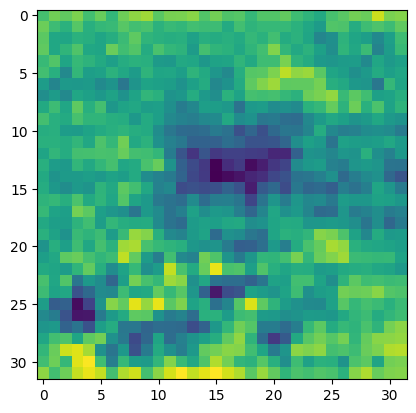

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)


plt.imshow(generated_image[0, :, :, 0], )

In [ ]:
discriminator(generated_image) > 0

<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[ True]])>